In [1]:
from src.datasets.Dataset_PESO import Dataset_PESO
from src.utils.Study import Study
from src.utils.ProjectConfiguration import ProjectConfiguration
from src.utils.BaselineConfigs import EXP_OctreeNCA
from src.datasets.Dataset_BCSS_Seg import Dataset_BCSS_Seg
from src.datasets.Dataset_AGGC import Dataset_AGGC
import octree_vis, torch, os, json, openslide, math
import einops
from src.models.Model_OctreeNCAV2 import OctreeNCAV2
import numpy as np
import torch.nn.functional as F
from src.utils.ProjectConfiguration import ProjectConfiguration as pc
from src.models.Model_OctreeNCA_2d_patching2 import OctreeNCA2DPatch2
import matplotlib.pyplot as plt
from src.utils.BaselineConfigs import EXP_UNet2D

torch.set_grad_enabled(False)

/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from src.models.UNetWrapper2D import UNetWrapper2D


model_path = "/local/scratch/clmn1/octree_study_new/Experiments/peso_unet_UNet2DSegmentation/"


with open(os.path.join(model_path, "config.json")) as f:
    config = json.load(f) 

exp = EXP_UNet2D().createExperiment(config, detail_config={}, 
                                                      dataset_class=Dataset_PESO, dataset_args={
                                                            'patches_path': os.path.join(pc.FILER_BASE_PATH, config['experiment.dataset.patches_path']),
                                                            'patch_size': config['experiment.dataset.input_size'],
                                                            'path': os.path.join(pc.FILER_BASE_PATH, config['experiment.dataset.img_path']),
                                                            'img_level': config['experiment.dataset.img_level']
                                                      })

model: UNetWrapper2D = exp.model
assert isinstance(model, UNetWrapper2D)
model = model.eval()
#model = model.cpu()

loading patches
Loaded configuration is missing keys: '['experiment.run_hash']'. Check if you are loading the correct experiment.
Reload State 2000
loading patches
loading patches

-------- Experiment Setup --------
{
    "experiment.name": "peso_unet",
    "experiment.description": "UNet2DSegmentation",
    "model.output_channels": 1,
    "trainer.optimizer": "torch.optim.Adam",
    "trainer.optimizer.lr": 0.0016,
    "trainer.optimizer.betas": [
        0.9,
        0.99
    ],
    "trainer.lr_scheduler": "torch.optim.lr_scheduler.ExponentialLR",
    "trainer.lr_scheduler.gamma": 0.9992002799440071,
    "trainer.update_lr_per_epoch": true,
    "trainer.normalize_gradients": null,
    "trainer.n_epochs": 2000,
    "trainer.find_best_model_on": null,
    "trainer.always_eval_in_last_epochs": null,
    "trainer.ema": false,
    "trainer.ema.decay": 0.99,
    "trainer.ema.update_per": "epoch",
    "experiment.dataset.img_path": "PESO/peso_training",
    "experiment.dataset.label_path": "

In [3]:
subject = "14"
pos_x, pos_y = 14400, 24320
#pos_x, pos_y = 14400-500, 24320-500
#pos_x, pos_y = 14400 + 1100, 24320 + 400
size = (16*161, 16*161)
#size = (320, 320)
#size = (320, 320*2)


print(size)
slide = openslide.open_slide(f"/local/scratch/PESO/peso_training/pds_{subject}_HE.tif")
slide = slide.read_region((int(pos_x * slide.level_downsamples[1]),
                           int(pos_y * slide.level_downsamples[1])), 1, size)
#slide = slide.read_region((int(pos_x * slide.level_downsamples[1]),
#                           int(pos_y * slide.level_downsamples[1])), 1, (16*10, 16*10))
slide = np.array(slide)[:,:,0:3]
slide_cpu = slide

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
slide = slide / 255.0
slide = (slide - mean) / std

slide = slide[None]
slide = torch.from_numpy(slide).float()
slide.names = ('B', 'H', 'W', 'C')
slide.names = (None, None, None, None)
slide = einops.rearrange(slide, 'B H W C -> B C H W')

(2576, 2576)


/tmp/ipykernel_22617/1724941962.py:26: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1921.)
  slide.names = ('B', 'H', 'W', 'C')


In [4]:
slide = slide.cuda()
out = model(slide)['logits'].cpu().numpy()[0]
#out = einops.rearrange(out, 'B H W C -> B C H W')

/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nlemke/remote/miniconda3/envs/nca3/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


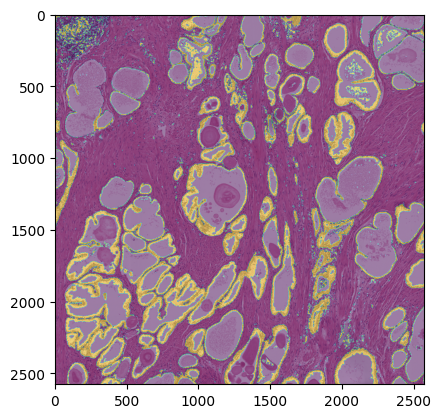

In [5]:
import matplotlib.pyplot as plt

plt.imshow(slide_cpu)
plt.imshow(out > 0, alpha=0.5)

In [6]:
print(model)

UNetWrapper2D(
  (model): UNet2D(
    (encoder): Encoder(
      (encoding_blocks): ModuleList(
        (0): EncodingBlock(
          (conv1): ConvolutionalBlock(
            (conv_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (activation_layer): ReLU()
            (block): Sequential(
              (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU()
            )
          )
          (conv2): ConvolutionalBlock(
            (conv_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (activation_layer): ReLU()
            (block): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): ReLU()
            )
          )
          (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): EncodingBlock(
          (conv1): ConvolutionalBlock(
            (conv_layer